In [4]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from datetime import datetime
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account("5fe30e6c8e71223b5549d253025a1f141713265617a67216a3f92d3dd3ea08be71b7676a82869b7ad89d2ddcd67a117acaf2e0434f3c525b730f30bb234df6e3", overwrite=True)
provider = IBMProvider()
from QLSTM import SequenceDataset
import yfinance as yf
from pandas_datareader import data as pdr

ModuleNotFoundError: No module named 'torch'

In [ ]:
df = pd.read_csv("final_combined_mutation_dataset.csv")


In [ ]:
columns = ['Open', 'High', 'Low', 'Close']

In [ ]:
columns = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = "Mutation_Label"
features = columns

# Include the target column too
df_train = df_train[columns + [target]]
df_test = df_test[columns + [target]]


In [ ]:
data = df.filter(columns)
dataset = data.values

In [ ]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
# Correctly split original dataframe
df_train = df.iloc[:size].copy()
df_test = df.iloc[size:].copy()

In [ ]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [ ]:
# Only normalize numeric columns
numeric_cols = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']
target = 'Mutation_Label'

# Normalize only the numeric part
df_train[numeric_cols], min_train, max_train = normalize(df_train[numeric_cols])
df_test[numeric_cols], _, _ = normalize(df_test[numeric_cols], min_train, max_train)


In [ ]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 3])
Target shape: torch.Size([1])


In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [ ]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [ ]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 285


In [ ]:
from torch.utils.data import Subset, DataLoader

# ⚡ Reduce dataset size
small_train = Subset(train_dataset, range(100))
small_test = Subset(test_dataset, range(100))

# ⚡ Use smaller batch size for speed
train_loader = DataLoader(small_train, batch_size=8, shuffle=True)
test_loader = DataLoader(small_test, batch_size=8, shuffle=False)

# Training loop
quantum_loss_train = []
quantum_loss_test = []

print("Untrained test\n--------")
test_loss = test_model(test_loader, Qmodel, loss_function)
quantum_loss_test.append(test_loss)

num_epochs = 10  # ⚡ Fewer epochs for speed

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)


Untrained test
--------
Test loss: 0.2784691258118703
Epoch 0
---------
Train loss: 0.24983927722160632
Test loss: 0.24766664665478927
Execution time 58.529375314712524
Epoch 1
---------
Train loss: 0.2546720275512108
Test loss: 0.2506392437678117
Execution time 59.46883678436279
Epoch 2
---------
Train loss: 0.24785878681219542
Test loss: 0.2611732093187479
Execution time 54.86148762702942
Epoch 3
---------
Train loss: 0.2523054904662646
Test loss: 0.2564953680221851
Execution time 58.427478551864624
Epoch 4
---------
Train loss: 0.25452115214787996
Test loss: 0.25974821471250975
Execution time 60.23194622993469
Epoch 5
---------
Train loss: 0.2505974689355263
Test loss: 0.2537292391061783
Execution time 62.97806692123413
Epoch 6
---------
Train loss: 0.25160890703017896
Test loss: 0.2544211997435643
Execution time 63.147719860076904
Epoch 7
---------
Train loss: 0.2505883150375806
Test loss: 0.25199079742798436
Execution time 55.007399559020996
Epoch 8
---------
Train loss: 0.2512330

In [ ]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

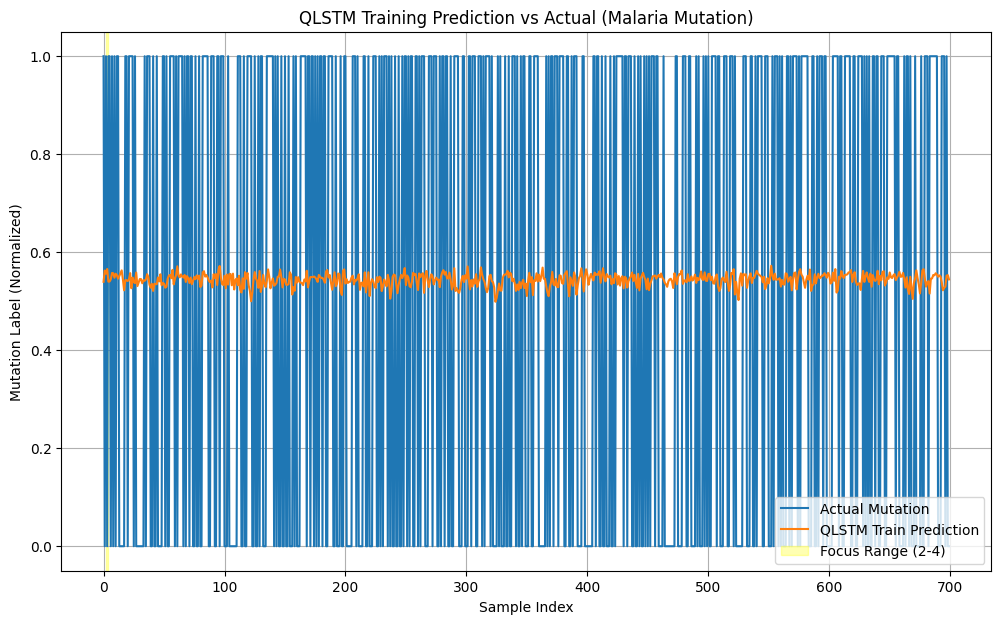

In [ ]:
plt.figure(figsize=(12, 7))

# Plot actual and predicted
plt.plot(range(len(df_train)), df_train["Mutation_Label"], label="Actual Mutation")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label="QLSTM Train Prediction")

# Highlight index range from 2 to 4
plt.axvspan(2, 4, color='yellow', alpha=0.3, label="Focus Range (2-4)")

# Labels and grid
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.title("QLSTM Training Prediction vs Actual (Malaria Mutation)")
plt.show()


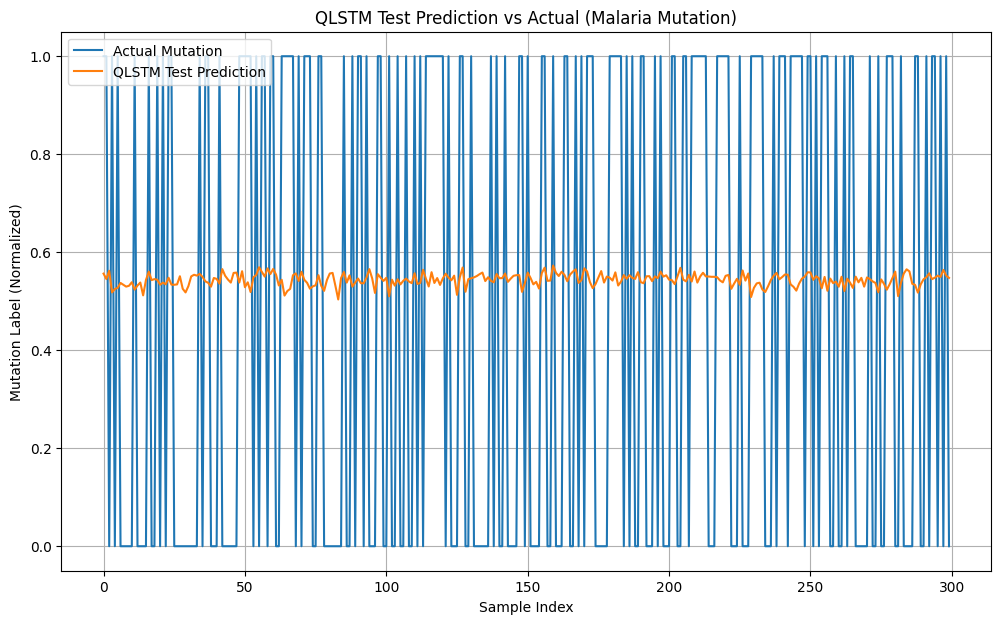

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Mutation_Label"], label="Actual Mutation")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label="QLSTM Test Prediction")
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.title("QLSTM Test Prediction vs Actual (Malaria Mutation)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(df_train["Mutation_Label"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Mutation_Label"], df_test["Model Forecast"]))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.5015778084673702
Test RMSE: 0.5063967115427276


In [ ]:
import numpy as np  # just in case

# ✅ Correct binary accuracy function
def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Convert predictions to binary (0 or 1) using 0.5 threshold
    y_pred_binary = (y_pred > 0.5).astype(int)

    return (y_pred_binary == y_true).mean()

# Use it
train_accuracy = accuracy(df_train["Mutation_Label"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Mutation_Label"], df_test["Model Forecast"])

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Train accuracy: 0.5071
Test accuracy: 0.4600


In [ ]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_mutation_Model.pt")

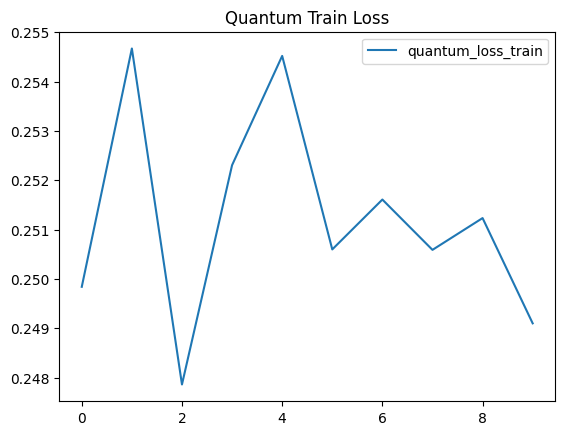

In [ ]:
plt.plot(quantum_loss_train, label='quantum_loss_train')
# plt.plot(quantum_loss_test, label='quantum_loss_test')  # Uncomment if you have test loss
pd.DataFrame(quantum_loss_train).to_csv('QLSTM_loss.csv', index=False)
plt.title('Quantum Train Loss')
plt.legend()
plt.show()


In [ ]:
from QLSTM import QLSTM  # or from your own definition

input_dim = 3          # Encoded_Sequence, Geo_Location, Body_Temperature
hidden_dim = 32
num_layers = 1
output_dim = 1

quantum_model = QLSTM(input_dim, hidden_dim, num_layers, output_dim)


weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 1)


In [ ]:
torch.save(quantum_model.state_dict(), "quantum_model.pth")


In [ ]:
quantum_model.load_state_dict(torch.load("quantum_model.pth"))
quantum_model.eval()


QLSTM(
  (clayer_in): Linear(in_features=35, out_features=1, bias=True)
  (clayer_out): Linear(in_features=1, out_features=32, bias=True)
)

In [ ]:
import pandas as pd

# Predict for entire test_dataset
quantum_model.eval()
all_inputs = []
all_predictions = []

with torch.no_grad():
    for x_batch, _ in test_eval_loader:
        preds = quantum_model(x_batch).cpu().numpy().flatten()
        all_predictions.extend(preds)

# Save predictions to CSV
df_result = pd.DataFrame({"Predicted Mutation %": all_predictions})
df_result.to_csv("mutation_predictions.csv", index=False)
print("✅ Predictions saved to 'quantum_mutation_predictions.csv'")


NameError: name 'quantum_model' is not defined